In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import SBDataset
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
from torch.utils.data import Dataset

class SBDWithTransforms(Dataset):
    def __init__(self, base_dataset, img_transform=None, mask_transform=None):
        self.base = base_dataset
        self.img_transform = img_transform
        self.mask_transform = mask_transform

    def __len__(self):
        return len(self.base)

    def __getitem__(self, idx):
        img, mask = self.base[idx]

        if self.img_transform is not None:
            img = self.img_transform(img)

        if self.mask_transform is not None:
            mask = self.mask_transform(mask)

        return img, mask


In [3]:
from torch.utils.data import Subset, random_split

transform_img = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

transform_mask = transforms.Compose([
    transforms.Resize((256, 256), interpolation=transforms.InterpolationMode.NEAREST),
    transforms.PILToTensor()
])

sbd_train_base = SBDataset(
    root="data",
    image_set="train",
    mode="segmentation",
    download=False
)

sbd_val_base = SBDataset(
    root="data",
    image_set="val",
    mode="segmentation",
    download=False
)

train_dataset = SBDWithTransforms(
    sbd_train_base,
    img_transform=transform_img,
    mask_transform=transform_mask
)

test_dataset = SBDWithTransforms(
    sbd_val_base,
    img_transform=transform_img,
    mask_transform=transform_mask
)

train_sub_dataset = Subset(train_dataset, range(4000))

dataset_size = len(train_sub_dataset)
val_size = int(0.2 * dataset_size)
train_size = dataset_size - val_size

train_ds, val_ds = random_split(
    train_sub_dataset,
    [train_size, val_size],
    generator=torch.Generator().manual_seed(42)
)

train_loader = DataLoader(train_ds,
                          batch_size=8,
                          shuffle=True,
                          num_workers=0,
                          pin_memory=True,
                          persistent_workers=False)

val_loader = DataLoader(val_ds,
                        batch_size=8,
                        shuffle=False,
                        num_workers=0,
                        pin_memory=True,
                        persistent_workers=False
)


In [4]:
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)


In [5]:
class UNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        self.down1 = DoubleConv(3, 64)
        self.down2 = DoubleConv(64, 128)
        self.down3 = DoubleConv(128, 256)

        self.pool = nn.MaxPool2d(2)

        self.middle = DoubleConv(256, 512)

        self.up3 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.conv3 = DoubleConv(512, 256)

        self.up2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.conv2 = DoubleConv(256, 128)

        self.up1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.conv1 = DoubleConv(128, 64)

        self.out = nn.Conv2d(64, num_classes, 1)

    def forward(self, x):
        c1 = self.down1(x)
        c2 = self.down2(self.pool(c1))
        c3 = self.down3(self.pool(c2))

        m = self.middle(self.pool(c3))

        u3 = self.up3(m)
        u3 = self.conv3(torch.cat([u3, c3], dim=1))

        u2 = self.up2(u3)
        u2 = self.conv2(torch.cat([u2, c2], dim=1))

        u1 = self.up1(u2)
        u1 = self.conv1(torch.cat([u1, c1], dim=1))

        return self.out(u1)


In [6]:
def train_model(model, train_loader, val_loader, optimizer, criterion, device, epochs):
    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

    for epoch in range(epochs):
        model.train()
        train_total, train_correct, train_loss = 0, 0, 0

        train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Train]",leave=False)

        for imgs, masks in train_bar:
            imgs = imgs.to(device)
            masks = masks.squeeze(1).long().to(device)

            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, masks)

            loss.backward()
            optimizer.step()

            preds = outputs.argmax(dim=1)
            valid = masks != 255

            train_correct += (preds[valid] == masks[valid]).sum().item()
            train_total += valid.sum().item()
            train_loss += loss.item()

            train_bar.set_postfix(
                loss=loss.item(),
                accuracy=100*train_correct / train_total
            )

        train_loss /= len(train_loader)
        train_acc = 100 * train_correct / train_total

        val_loss, val_acc = validate(model, val_loader)

        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        print(
            f"Epoch {epoch+1}/{epochs} | "
            f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f} | "
            f"Train Acc: {train_acc:.2f}, Val Acc: {val_acc:.2f}%"
        )

    return history


In [7]:
def validate(model, loader,epoch=None, epochs=None):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    desc = "Validation" if epoch is None else f"Epoch {epoch+1}/{epochs} [Val]"
    val_bar = tqdm(train_loader, desc=desc, leave=False)

    with torch.no_grad():
        for imgs, masks in val_bar:
            imgs = imgs.to(device)
            masks = masks.squeeze(1).long().to(device)

            outputs = model(imgs)
            loss = criterion(outputs, masks)
            total_loss += loss.item()

            preds = outputs.argmax(dim=1)
            valid = masks != 255
            correct += (preds[valid] == masks[valid]).sum().item()
            total += valid.sum().item()

            val_bar.set_postfix(
                loss=loss.item(),
                accuracy=100 * correct / total
            )

    val_loss = total_loss / len(loader)
    val_acc = 100.0 * correct / total
    return val_loss, val_acc


In [8]:
def plot_training_curves(results_dict):
    plt.figure(figsize=(12,5))

    # ---- Training Loss ----
    plt.subplot(2,2,1)
    for name, history in results_dict.items():
        plt.plot(history["train_loss"], label=f"{name} Train Loss")
    plt.title("Training Loss Comparison")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(2,2,2)
    for name, history in results_dict.items():
        plt.plot(history["train_acc"], label=f"{name} Train Accuracy")
    plt.title("Training Accuracy Comparison")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    # ---- Validation Accuracy ----
    plt.subplot(2,2,3)
    for name, history in results_dict.items():
        plt.plot(history["val_loss"], label=f"{name} Val Loss")
    plt.title("Validation Loss Comparison")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(2,2,4)
    for name, history in results_dict.items():
        plt.plot(history["val_acc"], label=f"{name} Val Acc")
    plt.title("Validation Accuracy Comparison")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.legend()

    plt.tight_layout()
    plt.show()


In [9]:
def show_predictions_segmentation(model, dataset, device, n):
    model.eval()

    import random
    idxs = random.sample(range(len(dataset)), n)

    plt.figure(figsize=(12, n * 3))

    for i, idx in enumerate(idxs):
        img, mask = dataset[idx]

        with torch.no_grad():
            pred = model(img.unsqueeze(0).to(device))
            pred = torch.argmax(pred, dim=1).squeeze().cpu()

        # Image
        plt.subplot(n, 3, i*3 + 1)
        plt.imshow(img.permute(1,2,0))
        plt.title("Image")
        plt.axis("off")

        # GT
        plt.subplot(n, 3, i*3 + 2)
        plt.imshow(mask.squeeze(), cmap="jet")
        plt.title("Ground Truth")
        plt.axis("off")

        # Prediction
        plt.subplot(n, 3, i*3 + 3)
        plt.imshow(pred, cmap="jet")
        plt.title("Prediction")
        plt.axis("off")

    plt.tight_layout()
    plt.show()


In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))


num_classes = 21  # SBD semantic classes
model = UNet(num_classes).to(device)

criterion = nn.CrossEntropyLoss(ignore_index=255)
optimizer = optim.Adam(model.parameters(), lr=1e-4)


cuda
True
NVIDIA GeForce GTX 1660


Training with epochs=3


Epoch 1/3 | Train Loss: 1.4640, Val Loss: 5.2384 | Train Acc: 68.96, Val Acc: 70.47%


Epoch 2/3 | Train Loss: 1.2944, Val Loss: 5.0995 | Train Acc: 70.47, Val Acc: 70.47%


Epoch 3/3 | Train Loss: 1.2759, Val Loss: 5.0222 | Train Acc: 70.47, Val Acc: 70.47%
Training with epochs=6


Epoch 1/6 | Train Loss: 1.4856, Val Loss: 5.2119 | Train Acc: 67.60, Val Acc: 70.47%


Epoch 2/6 | Train Loss: 1.2992, Val Loss: 5.1075 | Train Acc: 70.47, Val Acc: 70.47%


Epoch 3/6 | Train Loss: 1.2816, Val Loss: 5.0483 | Train Acc: 70.47, Val Acc: 70.47%


Epoch 4/6 | Train Loss: 1.2640, Val Loss: 5.2693 | Train Acc: 70.47, Val Acc: 70.47%


Epoch 5/6 | Train Loss: 1.2532, Val Loss: 4.9521 | Train Acc: 70.47, Val Acc: 70.47%


Epoch 6/6 | Train Loss: 1.2427, Val Loss: 4.9155 | Train Acc: 70.47, Val Acc: 70.51%
Training with epochs=9


Epoch 1/9 | Train Loss: 1.4875, Val Loss: 5.1998 | Train Acc: 67.91, Val Acc: 70.47%


Epoch 2/9 | Train Loss: 1.3012, Val Loss: 5.0934 | Train Acc: 70.47, Val Acc: 70.47%


Epoch 3/9 | Train Loss: 1.2746, Val Loss: 5.1051 | Train Acc: 70.47, Val Acc: 70.46%


Epoch 4/9 | Train Loss: 1.2601, Val Loss: 5.0803 | Train Acc: 70.48, Val Acc: 70.47%


Epoch 5/9 | Train Loss: 1.2529, Val Loss: 4.9699 | Train Acc: 70.46, Val Acc: 70.43%


Epoch 6/9 | Train Loss: 1.2409, Val Loss: 4.9260 | Train Acc: 70.49, Val Acc: 70.53%


Epoch 7/9 | Train Loss: 1.2299, Val Loss: 4.8516 | Train Acc: 70.77, Val Acc: 71.09%


Epoch 8/9 | Train Loss: 1.2247, Val Loss: 4.8059 | Train Acc: 70.85, Val Acc: 71.00%


Epoch 9/9 | Train Loss: 1.2073, Val Loss: 4.7635 | Train Acc: 71.07, Val Acc: 71.17%


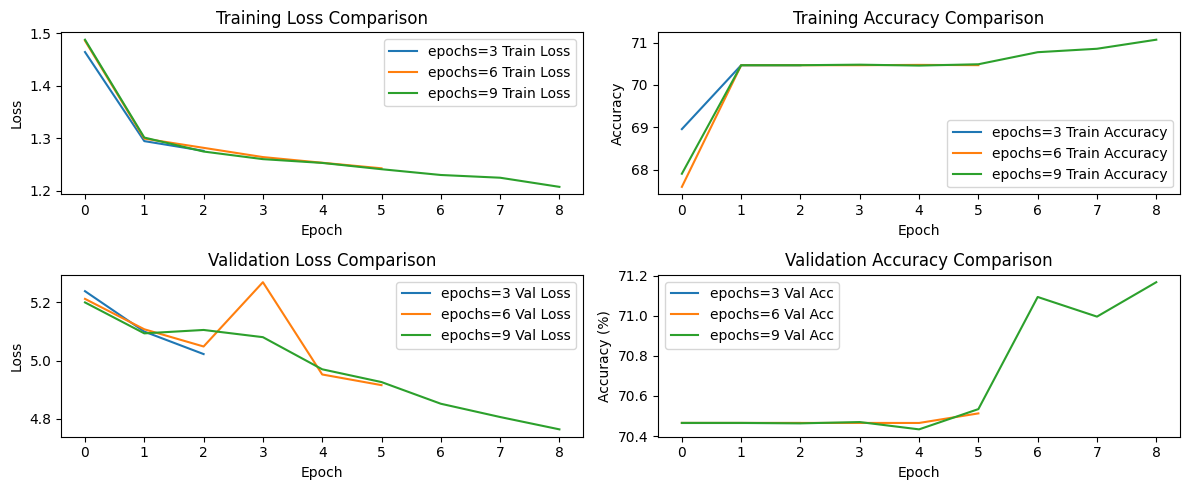

In [11]:
results = {}

for epoch in [3, 6, 9]:
    print(f"Training with epochs={epoch}")

    model = UNet(num_classes).to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    criterion = nn.CrossEntropyLoss(ignore_index=255)

    history = train_model(model, train_loader, val_loader, optimizer, criterion, device, epochs=epoch)

    results[f"epochs={epoch}"] = history


plot_training_curves(results)

Training with lr=0.01


Epoch 1/5 | Train Loss: 381.1887, Val Loss: 5.4217 | Train Acc: 66.47, Val Acc: 70.47%


Epoch 2/5 | Train Loss: 1.3584, Val Loss: 5.4280 | Train Acc: 70.47, Val Acc: 70.47%


Epoch 3/5 | Train Loss: 1.3590, Val Loss: 5.4287 | Train Acc: 70.47, Val Acc: 70.47%


Epoch 4/5 | Train Loss: 1.3587, Val Loss: 5.4366 | Train Acc: 70.47, Val Acc: 70.47%


Epoch 5/5 | Train Loss: 1.3599, Val Loss: 5.4269 | Train Acc: 70.47, Val Acc: 70.47%
Training with lr=0.001


Epoch 1/5 | Train Loss: 1.4599, Val Loss: 5.2906 | Train Acc: 68.18, Val Acc: 70.47%


Epoch 2/5 | Train Loss: 1.3117, Val Loss: 5.3514 | Train Acc: 70.47, Val Acc: 70.47%


Epoch 3/5 | Train Loss: 1.2738, Val Loss: 5.1337 | Train Acc: 70.49, Val Acc: 70.87%


Epoch 4/5 | Train Loss: 1.2617, Val Loss: 5.0141 | Train Acc: 70.74, Val Acc: 71.00%


Epoch 5/5 | Train Loss: 1.2525, Val Loss: 4.9317 | Train Acc: 70.81, Val Acc: 71.08%
Training with lr=0.0001


Epoch 1/5 | Train Loss: 1.4785, Val Loss: 5.2206 | Train Acc: 69.73, Val Acc: 70.47%


Epoch 2/5 | Train Loss: 1.2977, Val Loss: 5.1580 | Train Acc: 70.47, Val Acc: 70.47%


Epoch 3/5 | Train Loss: 1.2869, Val Loss: 5.1064 | Train Acc: 70.47, Val Acc: 70.47%


Epoch 4/5 | Train Loss: 1.2767, Val Loss: 5.0896 | Train Acc: 70.47, Val Acc: 70.47%


Epoch 5/5 | Train Loss: 1.2670, Val Loss: 5.0040 | Train Acc: 70.47, Val Acc: 70.47%


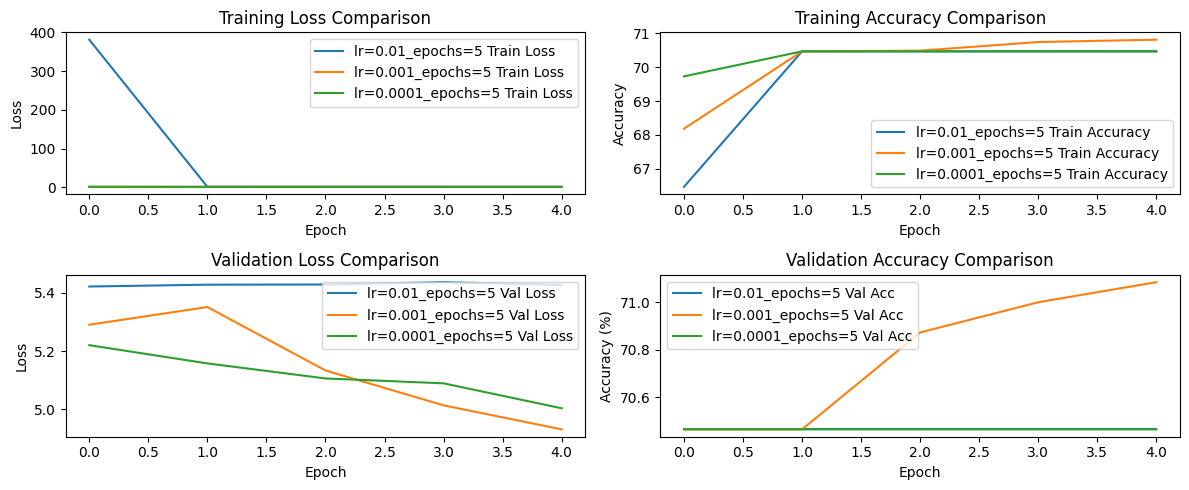

In [12]:
lrs = [1e-2,1e-3,1e-4]
results = {}
for lr in lrs:
    print(f"Training with lr={lr}")
    model = UNet(num_classes).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss(ignore_index=255)

    history = train_model(model, train_loader, val_loader, optimizer, criterion, device, epochs=5)

    results[f"lr={lr}_epochs=5"] = history

plot_training_curves(results)

In [13]:
show_predictions_segmentation(model, val_loader, device, n=8)

TypeError: 'DataLoader' object is not subscriptable

<Figure size 1200x2400 with 0 Axes>